In [36]:
import torch
import torch.nn as nn
from torch.utils import data
from torchvision.models import vgg19, densenet121
from torchvision import transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np
import os

# Fix kernel dying error on matplotlib
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [37]:
# use the ImageNet transformation
transform = transforms.Compose([transforms.Resize((224, 224)), 
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

# define a 1 image dataset
dataset = datasets.ImageFolder(root='gradcam_data/', transform=transform)

# define the dataloader to load that single image
dataloader = data.DataLoader(dataset=dataset, shuffle=False, batch_size=1)

In [38]:
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        
        # get the pretrained VGG19 network
        self.vgg = vgg19(pretrained=True)
        
        # disect the network to access its last convolutional layer
        self.features_conv = self.vgg.features[:36]
        
        # get the max pool of the features stem
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        
        # get the classifier of the vgg19
        self.classifier = self.vgg.classifier
        
        # placeholder for the gradients
        self.gradients = None
    
    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients = grad
        
    def forward(self, x):
        x = self.features_conv(x)
        
        # register the hook
        h = x.register_hook(self.activations_hook)
        
        # apply the remaining pooling
        x = self.max_pool(x)
        x = x.view((1, -1))
        x = self.classifier(x)
        return x
    
    # method for the gradient extraction
    def get_activations_gradient(self):
        return self.gradients
    
    # method for the activation exctraction
    def get_activations(self, x):
        return self.features_conv(x)

In [39]:
# initialize the VGG model
vgg = VGG()

# set the evaluation mode
vgg.eval()

# get the image from the dataloader
img, _ = next(iter(dataloader))

# get the most likely prediction of the model
pred = vgg(img).argmax(dim=1)
pred

In [43]:
pred

tensor([491])

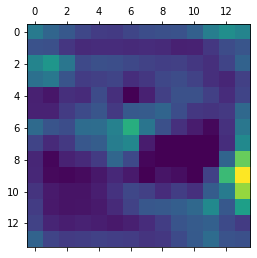

In [41]:
# get the gradient of the output with respect to the parameters of the model
vgg(img)[:, pred].backward()

# pull the gradients out of the model
gradients = vgg.get_activations_gradient()

# pool the gradients across the channels
pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

# get the activations of the last convolutional layer
activations = vgg.get_activations(img).detach()

# weight the channels by corresponding gradients
for i in range(512):
    activations[:, i, :, :] *= pooled_gradients[i]
    
# average the channels of the activations
heatmap = torch.mean(activations, dim=1).squeeze()

# relu on top of the heatmap
# expression (2) in https://arxiv.org/pdf/1610.02391.pdf
heatmap = np.maximum(heatmap, 0)

# normalize the heatmap
heatmap /= torch.max(heatmap)

# draw the heatmap
plt.matshow(heatmap.squeeze())

In [42]:
import cv2
img = cv2.imread('./gradcam_data/Elephant/1_oRpjlGC3sUy5yQJtpwclwg.jpeg')
heatmap = cv2.resize(heatmap.numpy(), (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img
cv2.imwrite('./map.jpg', superimposed_img)

True

In [25]:
class DenseNet(nn.Module):
    def __init__(self):
        super(DenseNet, self).__init__()
        
        # get the pretrained DenseNet201 network
        self.densenet = densenet121(pretrained=True)
        
        # disect the network to access its last convolutional layer
        self.features_conv = self.densenet.features
        
        # add the average global pool
        self.global_avg_pool = nn.AvgPool2d(kernel_size=7, stride=1)
        
        # get the classifier of the vgg19
        self.classifier = self.densenet.classifier
        
        # placeholder for the gradients
        self.gradients = None
    
    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients = grad
        
    def forward(self, x):
        x = self.features_conv(x)
        
        # register the hook
        h = x.register_hook(self.activations_hook)
        
        # don't forget the pooling
        x = self.global_avg_pool(x)
        x = x.view((1, 1024))
        x = self.classifier(x)
        return x
    
    def get_activations_gradient(self):
        return self.gradients
    
    def get_activations(self, x):
        return self.features_conv(x)

In [44]:
# initialize the VGG model
densenet = DenseNet()

# set the evaluation mode
densenet.eval()

# get the image from the dataloader
img, _ = next(iter(dataloader))

# get the most likely prediction of the model
pred = densenet(img).argmax(dim=1)
pred

tensor([981])

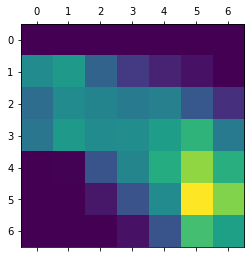

In [45]:
# get the gradient of the output with respect to the parameters of the model
densenet(img)[:, pred].backward()

# pull the gradients out of the model
gradients = densenet.get_activations_gradient()

# pool the gradients across the channels
pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

# get the activations of the last convolutional layer
activations = densenet.get_activations(img).detach()

# weight the channels by corresponding gradients
for i in range(512):
    activations[:, i, :, :] *= pooled_gradients[i]
    
# average the channels of the activations
heatmap = torch.mean(activations, dim=1).squeeze()

# relu on top of the heatmap
# expression (2) in https://arxiv.org/pdf/1610.02391.pdf
heatmap = np.maximum(heatmap, 0)

# normalize the heatmap
heatmap /= torch.max(heatmap)

# draw the heatmap
plt.matshow(heatmap.squeeze())

In [47]:
import cv2
img = cv2.imread('./gradcam_data/Elephant/1_oRpjlGC3sUy5yQJtpwclwg.jpeg')
heatmap = cv2.resize(heatmap.numpy(), (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img
cv2.imwrite('./map.jpg', superimposed_img)

True

In [33]:
superimposed_img

array([[[296. , 215. , 196. ],
        [296. , 215. , 196. ],
        [296. , 215. , 196. ],
        ...,
        [293.6, 201. , 188. ],
        [293.6, 201. , 188. ],
        [293.6, 201. , 188. ]],

       [[296. , 215. , 196. ],
        [296. , 215. , 196. ],
        [297. , 216. , 197. ],
        ...,
        [293.6, 201. , 188. ],
        [293.6, 201. , 188. ],
        [293.6, 201. , 188. ]],

       [[297. , 216. , 197. ],
        [297. , 216. , 197. ],
        [297. , 216. , 197. ],
        ...,
        [293.6, 201. , 188. ],
        [293.6, 201. , 188. ],
        [293.6, 201. , 188. ]],

       ...,

       [[126. , 112. , 102. ],
        [133. , 121. , 111. ],
        [161. , 151. , 138. ],
        ...,
        [114. ,  91. ,  84. ],
        [117. ,  95. ,  88. ],
        [108. ,  85. ,  80. ]],

       [[127. , 115. , 105. ],
        [145. , 134. , 124. ],
        [157. , 149. , 136. ],
        ...,
        [121. ,  97. ,  92. ],
        [116. ,  92. ,  87. ],
        [120. ,